## Modern Data Science 
**(Module 01: A Touch of Data Science)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use, change and distribute this package.

Prepared by and for 
**Student Members** |
2006-2018 [TULIP Lab](http://www.tulip.org.au), Australia

---


# Session I - Abnormality Analytics (2)

**The purpose of this session, which is continued from practical session 3, is to demonstrate advanced methods of abnormality analytics:**

1. Principal component analysis (PCA) based methods
2. Probabilistic Approach - Gaussian mixture model based methods

** References and additional reading and resources**
- [Novelty and outlier detection with scikit-learn](http://scikit-learn.org/stable/modules/outlier_detection.html)
---




 # <span style="color:#0b486b">1. Revisiting EMNIST dataset</span> 

 *__EMNIST__* dataset contains many of digit images and a few of non-digit images. Our aim is to train a model using this dataset to detect non-digit images. We can apply this model to build a machine to verify a valid phone number written by hand. You now can load EMNIST data (in csv format) and view data properties using the following code. The first column represents labels of data instances. The rest are feature vectors of data instances.

Now you can load data and get some basic information of dataset using <code>info()</code> function.

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv('emnist.digits_letters.small.csv',index_col=0)
df = df.sort_values(['0'])  # for further visualization
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 0 to 1998
Columns: 785 entries, 0 to 784
dtypes: float64(678), int64(107)
memory usage: 12.0 MB


Converting the data frame *df* to a numpy array object *data_array* for using *numpy* array utility methods.

In [2]:
data_array = df.as_matrix()
x = data_array[:,1:]
y_true = data_array[:,0]
num_samples = x.shape[0]
print("\nNumber of samples: {}".format(num_samples))



Number of samples: 1999


Since the dataset contains images, you can sample and plot some digits images (labeled as 1) in the dataset. Note that you need to reshape to a matrix before using `imshow()` to view this image because the feature vector is flattened in 1D.

/usr/local/src/conda3_runtime.v27/4.1.1/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Populating the interactive namespace from numpy and matplotlib


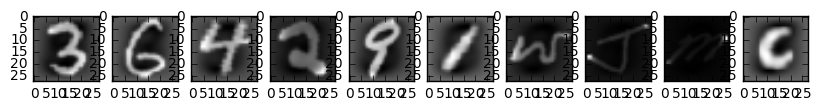

In [3]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6) # configure the size of images

import matplotlib.pyplot as plt 
num_dig_subplots = 5                                 # the number of digit images plotted
num_let_subplots = 5                                 # the number of letter images plotted                                     
# the number of images plotted
fig, ax = plt.subplots(1,num_dig_subplots+num_let_subplots)
# Plotting digits
for idx in range(num_dig_subplots):
    n = np.random.randint(np.sum(y_true < 0), len(y_true))      # randomly choose an image index
    img1 = x[n,:].reshape((28,28)).T                  # reshape the vector into the image size 28x28
    ax[idx].imshow(img1, cmap = plt.get_cmap('gray')) # show the selected image
    
# Plotting letters
for idx in range(num_let_subplots):
    n = np.random.randint(0,np.sum(y_true < 0))      # randomly choose an image index
    img1 = x[n,:].reshape((28,28)).T                  # reshape the vector into the image size 28x28
    ax[idx+num_dig_subplots].imshow(img1, cmap = plt.get_cmap('gray')) # show the selected image

plt.show()


## Dataset Statistics

First, we examine the ratio between normal data (labeled as **'1'**) and abnormal data (labeled as **'-1'**). Intuitively, we can see it is an imbalanced dataset.

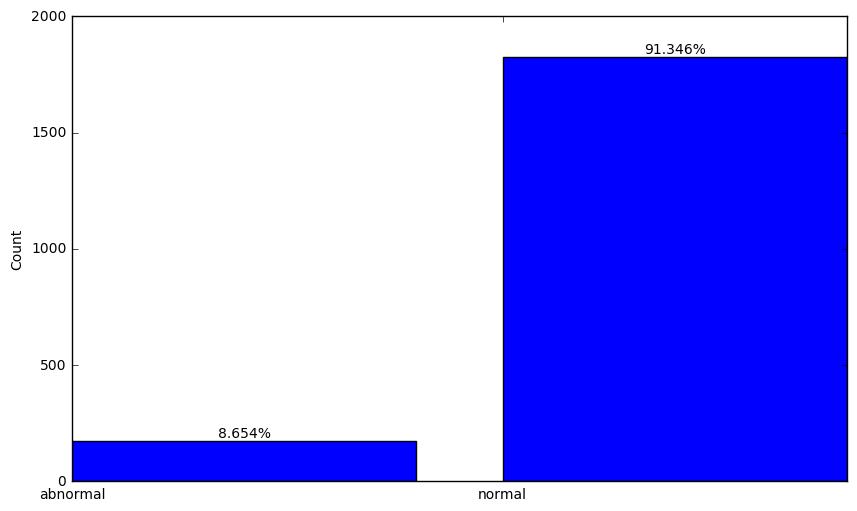

In [4]:
import matplotlib.pyplot as plt
(counts, _) = np.histogram(y_true,2)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar([0,1], counts)
classlabels=["abnormal","normal"]

rects =ax.patches

# Now make labels of percentage
labels = ['{:.3f}%'.format(i*100) for i in counts/np.sum(counts)]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 2, label, ha='center', va='bottom')

plt.ylabel("Count")
plt.xticks(np.arange(2),classlabels)
plt.show()

# <span style="color:#0b486b"> 2.   Advanced Methods for Anomaly Detection Systems</span> 

In addition to the algorithms being introduced in previous practical session, we present here two advanced approaches for abnormality  analytics:
 - PCA-based approach
 - Probabilistic approach using Gaussian mixture models (GMM)

## II.1 PCA-based approach

In  $PCA$  algorithm, we need to find a subspace of  $𝑑$ principal components to approximate dataset $X$. This original matrix $X$ now can be seen  as the sum of two orthogonal parts: an approximated data matrix $\tilde{X}$ and a residual data matrix $E$, which is intuitively represented in the following figure.
<img src="https://raw.githubusercontent.com/tuliplab/mds/master/Jupyter/image/PCAResidual.png" width="600">


In PCA-based algorithm for abnormality analytics, we use residual data matrix $E$ to detect anomalies. The pseudo-code of the algorithms is

<img src="https://raw.githubusercontent.com/tuliplab/mds/master/Jupyter/image/PCAResidual_algo.png" width="600">

Now we step-by-step implement the algorithm. Firstly, we compute covariance matrix

In [5]:
cov_mat = np.cov(x[y_true > 0,:].T)  # only consider normal data

and decompose covariance matrix using SVD method.

In [6]:
[U, S, V] = np.linalg.svd(cov_mat)

We can find the number of principal components with a certain of info kept.

In [7]:
# set model hyper-parameters
find_threshold_type = 'percentile'
keep_info = 0.999
alpha = 0.3  # use for find_threshold_type = 'keepinfo'
normal_percent = 90  # use for find_threshold_type = 'percentile'

cs = S.cumsum()
num_principal_components = int(np.where(cs >= cs[-1]*keep_info)[0][0]+1)
print('Number of principal components:', num_principal_components)

Number of principal components: 502


We calculate the principal subspace and residual subspace, and project data onto residual subspace to get the residual signal.

In [8]:
U1 = U[:, :num_principal_components]    # principal subspace
U2 = U[:, num_principal_components:]     # residual subspace

resid = np.power(x.dot(U2.dot(U2.T)),2).sum(axis=1)   # project onto residual subspace

A data point is abnormal if residual signal is very high. Thus, by defining a threshold, we can detect anomaly.

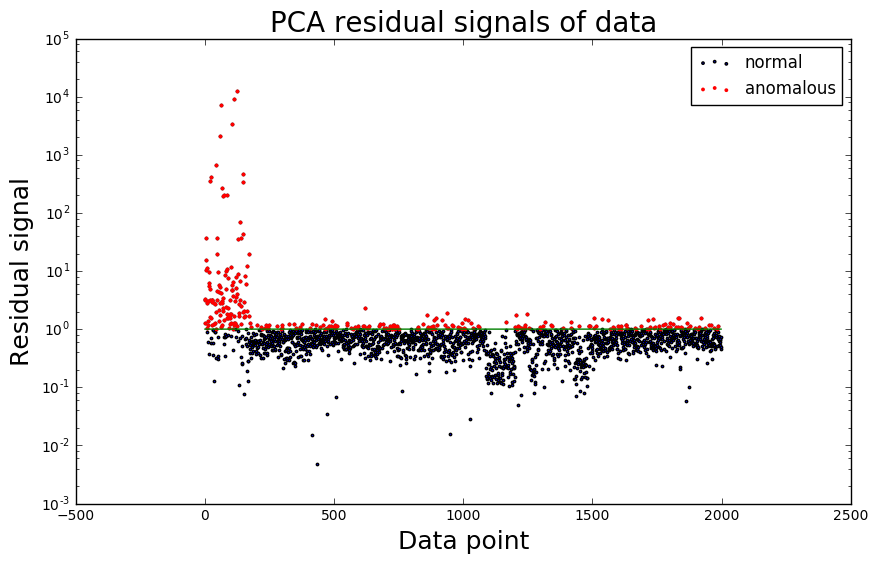

In [9]:
threshold = 1.0
# now we visualize residual signal and threshold
# we mark anomalies as red data points 
import matplotlib.pyplot as plt
data_idx = np.arange(num_samples)
plt.scatter(data_idx, resid,s=3,label='normal')
plt.scatter(data_idx[resid>threshold], resid[resid>threshold], color='red',s=3,label='anomalous')
threshold_line = np.ones(num_samples) * threshold
plt.plot(data_idx, threshold_line, color='green')
plt.yscale('log')
plt.xlabel('Data point',fontsize=18)
plt.ylabel('Residual signal',fontsize=18)
plt.title('PCA residual signals of data',fontsize=20)
plt.legend()
plt.show()

Finally, we can report the prediction performance.

In [10]:
from sklearn import metrics

y_predict = np.ones(num_samples)
y_predict[resid > threshold] = -1
print('Classification results:')
print(metrics.classification_report(y_true, y_predict))

confusion_mat = metrics.confusion_matrix(y_true, y_predict, [1, -1])
print('Confusion matrix')
df_confusion = pd.DataFrame(confusion_mat, columns=['Prediction Positive ','Prediction Negative'])
df_confusion.index = ['Original Positive','Original Negative']
df_confusion

Classification results:
             precision    recall  f1-score   support

       -1.0       0.41      0.72      0.53       173
        1.0       0.97      0.90      0.94      1826

avg / total       0.92      0.89      0.90      1999

Confusion matrix


,Prediction Positive,Prediction Negative
Original Positive,1651,175
Original Negative,49,124


Our question is whether we can determine automatically threshold. What following is about choosing a threshold automatically.

In [12]:
def find_threshold_percentile(resid, args):
    percent = args
    return np.percentile(resid, percent)

def find_threshold_keepinfo(resid, args):
    (alpha, S, num_principal_components) = args
    c_alpha = scipy.stats.norm.ppf(1-alpha)
    phi1 = np.sum(S[num_principal_components+1:])
    phi2 = np.sum(S[num_principal_components+1:]**2)
    phi3 = np.sum(S[num_principal_components+1:]**3)
    h0 = 1 - (2*phi1*phi3)/(3*phi2*phi2)
    threshold = phi1 * (c_alpha*np.sqrt(2*phi2*h0*h0)/phi1 + 1 + (phi2*h0*(h0-1))/(phi1*phi1))**(1/h0)
    return threshold

if find_threshold_type == 'keepinfo':
    find_threshold = find_threshold_keepinfo
    args = (alpha, S, num_principal_components)
elif find_threshold_type == 'percentile':
    find_threshold = find_threshold_percentile
    args = normal_percent

# automatically compute threshold
threshold = find_threshold(resid, args)
print("Auto threshold = {}".format(threshold))

Auto threshold = 1.1166037229489862


We mark data points as anomalies if their residual signals are greater than the threshold. The residual signals and threshold are visualized in the following code.

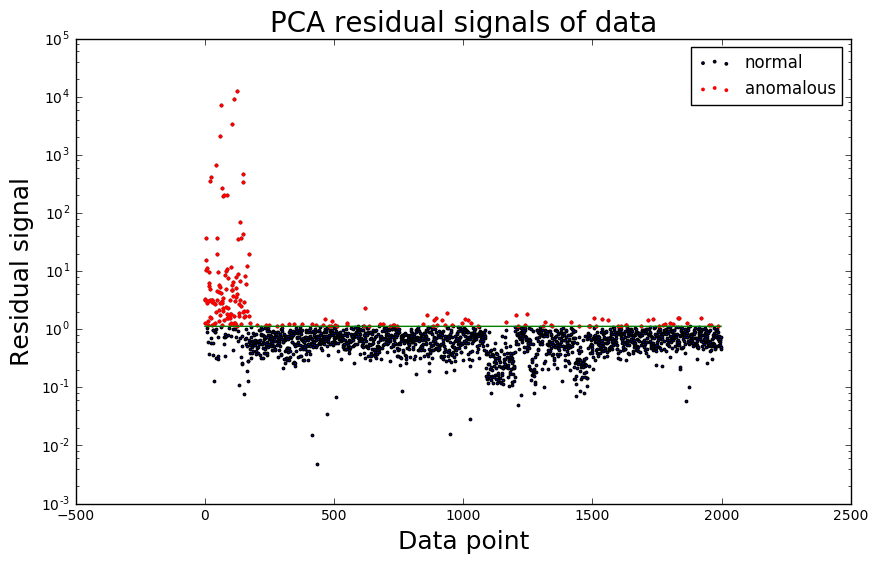

In [13]:
import matplotlib.pyplot as plt
data_idx = np.arange(num_samples)
plt.scatter(data_idx, resid,s=3,label='normal')
plt.scatter(data_idx[resid>threshold], resid[resid>threshold], color='red',s=3,label='anomalous')
threshold_line = np.ones(num_samples) * threshold
plt.plot(data_idx, threshold_line, color='green')
plt.yscale('log')
plt.xlabel('Data point',fontsize=18)
plt.ylabel('Residual signal',fontsize=18)
plt.title('PCA residual signals of data',fontsize=20)
plt.legend()
plt.show()

Finally, we can report the prediction performance.

In [14]:
from sklearn import metrics

y_predict = np.ones(num_samples)
y_predict[resid > threshold] = -1
print('Classification results:')
print(metrics.classification_report(y_true, y_predict))

confusion_mat = metrics.confusion_matrix(y_true, y_predict, [1, -1])
print('Confusion matrix')
df_confusion = pd.DataFrame(confusion_mat, columns=['Prediction Positive ','Prediction Negative'])
df_confusion.index = ['Original Positive','Original Negative']
df_confusion

Classification results:
             precision    recall  f1-score   support

       -1.0       0.59      0.69      0.64       173
        1.0       0.97      0.96      0.96      1826

avg / total       0.94      0.93      0.93      1999

Confusion matrix


,Prediction Positive,Prediction Negative
Original Positive,1745,81
Original Negative,54,119


We also have a ROC plot.

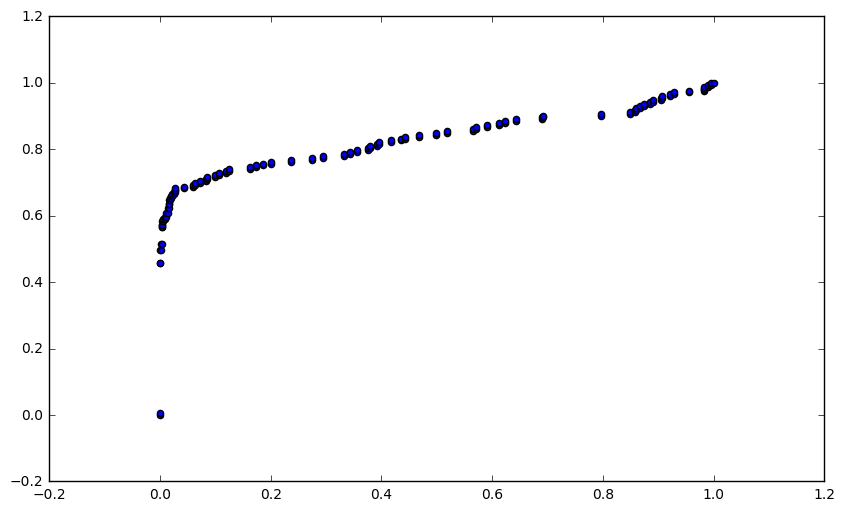

In [15]:
from sklearn import metrics
FPR, TPR, _ = metrics.roc_curve(y_true, resid, pos_label=[1])
plt.scatter(TPR,FPR)
plt.show()

## 2.2 Gaussian Mixture Model Approach


Gaussian Mixture model (GMM) is usually an unsupervised clustering model that is similar to k-means but has more robustness than k-means. However, Gaussian mixture model (GMM) can be used to detect anomalies in a dataset. We can use GMM to capture the density function of the dataset. If one data point receives a low probability assignment from the GMM learned from dataset, it can be classified as an anomalous item. In this figure below, we can learnt 2-component GMMs from given dataset, the red data points possess very low likelihoods (low log-likelihoods) then can be classified as anomalies.

<img src="https://raw.githubusercontent.com/tuliplab/mds/master/Jupyter/image/GMM.png" width="600">

The pseudo-code of the algorithms is

<img src="https://raw.githubusercontent.com/tuliplab/mds/master/Jupyter/image/GMM_algo.png" width="600">



Now, we build a class GMM for modelling data.

In [1]:
from sklearn import mixture

class clsGMM:
    def __init__(self, train_data, num_mixtures=5, percent_abnormal=0.005):
        self.num_mixtures = num_mixtures
        self.train_data= train_data
        self.percent_abnormal= percent_abnormal 
    
    def train(self):
        # Init Gaussian Mixture Model with 5 components
        self.g = mixture.GaussianMixture(self.num_mixtures)        # creating and fitting GMM model using sklearn library
        self.g.fit(self.train_data) 
        
    def predict(self, data):
        # Estimate log probability
        logprob = self.g.score_samples(data)
        logprob = logprob*(-1)
        logprob = logprob + abs(np.min(logprob)) + 0.5
        residual_signal = logprob;
        
        a = np.sort(residual_signal)
        threshold = a[int((1-self.percent_abnormal)*residual_signal.size)]
        
        num_samples = data.shape[0]
        y_predict = np.ones(num_samples)
        y_predict[residual_signal > threshold] = -1
        return y_predict


Using dataset loaded in the previous section, we can train the model

In [17]:
# set model hyper-parameters
num_mixtures = 5
percent_abnormal =0.1

# train on normal data
gmm = clsGMM(train_data=x[y_true > 0,:], num_mixtures=num_mixtures, percent_abnormal=percent_abnormal)
gmm.train()


AttributeError: module 'sklearn.mixture' has no attribute 'GaussianMixture'

The trained model is used to predict anomalous data points,

In [17]:
y_predict = gmm.predict(x)

and compute the predicting performance.

In [18]:
print('Classification results:')
print(metrics.classification_report(y_true, y_predict))

confusion_mat = metrics.confusion_matrix(y_true, y_predict, [1, -1])
print('Confusion matrix')
df_confusion = pd.DataFrame(confusion_mat, columns=['Prediction Positive ','Prediction Negative'])
df_confusion.index = ['Original Positive','Original Negative']
df_confusion

Classification results:
             precision    recall  f1-score   support

       -1.0       0.87      1.00      0.93       173
        1.0       1.00      0.99      0.99      1826

avg / total       0.99      0.99      0.99      1999

Confusion matrix


,Prediction Positive,Prediction Negative
Original Positive,1800,26
Original Negative,0,173


We can plot discovered data as follows

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


x_reduced = PCA(n_components=4).fit_transform(x)

# train on normal data
gmm = clsGMM(train_data=x[y_true > 0,:], num_mixtures=num_mixtures, percent_abnormal=percent_abnormal)
gmm.train()
y_predict = gmm.predict(x)

x_labels=gmm.g.predict(x)
fig = plt.figure(2, figsize=(15, 10))
# fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_normal=x_reduced[y_predict>0,:]
x_normal_labels=x_labels[y_predict>0]
ax.scatter(x_normal[:, 0], x_normal[:, 1], x_normal[:, 2], c=x_normal_labels, cmap='Accent')  # plot 2-d data where each data point is decorated with its label.

x_anormaly=x_reduced[y_predict<0,:]
ax.scatter(x_anormaly[:, 0], x_anormaly[:, 1],x_anormaly[:, 2], color='red',zdir='x')


ax.view_init(elev=10,azim=352)
plt.show()

## <span style="color:#0b486b">3. Practical Coding Exercises</span>

1. You can try to vary  *threshold,keep_info, alpha, normal_percent* values in the **PCA-based** algorithm and *number of clusters, percent_abnormal* for the **GMM-based** algorithm and report the best values for each algorithm in terms of F-measure.
2. We provide you a subset of [Statlog (German Credit Data) Data Set](https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)) in [**german.csv**](link_to_data = 'https://github.com/tuliplab/mds/blob/master/Jupyter/data/emnist.digits_letters.small.csv?raw=true'
). You can try to understand the data statistics and use two algorithms presented in Section II to dectect anomolies and report the results.